## 3D image classification from CT scans
### 3D CT图像分类 

原文链接：https://keras.io/examples/vision/3D_image_classification/

## Note:
一个用来检测新冠肺炎（Covid-19）CT图像的模型，话题比较应景，考虑到这篇文章最后一次改动是在 2020年9月23日，正值新冠肺炎在全世界蔓延，所以当时提出来确实是比较亮眼。而且这篇博客有一点做的比较好：他列出了参考文献，可以让我们学习模型结构的时候深入了解其原理。

----------

## Setup

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

-------------

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the MosMedData: Chest CT Scans with COVID-19 Related Findings. This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.  
在这个例子中，我们使用 MosMedData的一个子集：“新冠胸部CT相关影像”，这个数据集同时包含了正负样本，即有新冠肺炎的CT和无肺炎的CT。


We will be using the associated radiological findings of the CT scans as labels to build a classifier to predict presence of viral pneumonia. Hence, the task is a binary classification problem.  
使用CT影像结果为标签构建任务，因此是一个二分类问题。  

这个数据集是由俄罗斯莫斯科市政医院提供，在 [**Kaggle**](https://www.kaggle.com/andrewmvd/mosmed-covid19-ct-scans) 上有更具体的描述。

### 下载正常的CT图像

In [2]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

1065484288/1065471431 [==============================] - 98s 0us/step


'c:\\Users\\Lucks\\Desktop\\KerasExample\\KerasExample\\ComputerVision\\CT-0.zip'

### 下载异常的CT图像

In [3]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

1045176320/1045162547 [==============================] - 97s 0us/step


'c:\\Users\\Lucks\\Desktop\\KerasExample\\KerasExample\\ComputerVision\\CT-23.zip'

### 创建一个文件夹用来保存解压后的文件

In [4]:
os.makedirs("MosMedData")

### 解压文件

In [5]:
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

经过以上操作可以得到如下文件结构：  
```python
MosMedData/
    CT-0/ 正常
        study_0001.nii.gz   10.6 MB
        study_0002.nii.gz   10.4 MB
        ...
    CT-23/ 异常
        study_0939.nii.gz   12.9 MB
        study_0940.nii.gz   10.8 MB
        ...
```
每一个nii.gz压缩包中都只有对应的一份同名的nii文件，后面会简单介绍这种格式的文件。

-----------

## Loading data and preprocessing
The files are provided in Nifti format with the extension .nii. To read the scans, we use the nibabel package. You can install the package via pip install nibabel. CT scans store raw voxel intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset. Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold between -1000 and 400 is commonly used to normalize CT scans.  
这些文件是Nifit格式，后缀为.nii。为了读取影像数据需要用到**nibabel**包，通过pip安装这个包（执行下面的代码安装该包）。CT影像的数据单位是 **Hounsfield**（HU），在当前数据集中的值域为 [-1024, 2000], 这个值高于400通常是各种类型的骨骼（因为不同部位骨骼的放射性强度不同，但普遍在400以上），介于 [-1000, 400] 之间的通常是身体组织。  

这里补充一个小知识，**Houndsfield** 是英国科学家 G. Houndsfield 的姓，于1979年获得诺贝尔物理学奖，是公认的CT发明者。可以简单地认为 HU 值越高物质密度越大，空气的 HU=-1000，纯水的 HU=0，这就不难理解为什么400以上通常是骨骼了。

In [ ]:
!pip install nibabel

To process the data, we do the following:   
为了处理这些数据，我们还需要完成以下操作：  
* We first rotate the volumes by 90 degrees, so the orientation is fixed.
* 把体旋转90读将方向固定住。
* We scale the HU values to be between 0 and 1.
* 将HU值归一化到 [0, 1] 之间
* We resize width, height and depth.
* 调整图片长宽和帧数

【注】因为单张CT并不像RGB图像一样有多个通道的概念，可以认为是单通道的灰度图，但CT是由一系列图片组成的，原文中将其称为depth（深度），我更倾向于将其称为frame（帧），后面涉及到相关的部分我都会称为“帧”，希望留意下。

Here we define several helper functions to process the data. These functions will be used when building training and validation datasets.   
这里设计了几个辅助函数来处理数据，这些函数将用于构建训练集和验证集。

In [2]:
import nibabel as nib
from scipy import ndimage

### 读取nii文件

In [3]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

### 归一化
归一化和标准化其实是两个操作，但本质上都是一种线性变化。  

归一化：$\frac{X_{i}-X_{min}}{X_{max}-X_{min}}$  

标准化：$\frac{X_{i}-\mu}{\sigma}$  

其中 $\mu$ 代表均值；$\sigma$ 代表方差。

In [4]:
def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

### Resize

In [5]:
def resize_volume(img):
    """Resize across z-axis"""
    # 设置长、宽、帧
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # 获取当前长、宽、帧
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # 计算缩放因子
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # 旋转图片
    img = ndimage.rotate(img, 90, reshape=False)
    # 固定z轴（帧轴）进行缩放
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

### 预处理

In [6]:
def process_scan(path):
    volume = read_nifti_file(path)  # 读取
    volume = normalize(volume)      # 归一化
    volume = resize_volume(volume)  # 缩放
    return volume

Let's read the paths of the CT scans from the class directories.  
从文件夹中读取CT影像的**路径**。

### 正样本（无纤维化）

In [7]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

### 负样本（有纤维化）

In [8]:
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

In [9]:
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


--------

## Build train and validation datasets
构建训练集和验证集。  

博主在这里处理的不是很好，读取数据最好是在使用的时候读取，而不是一上来就全部读入放在内存中；所以在这步上是有很大的改正空间。  

实际上可以仿照 [Image segmentation with a U-Net-like architecture](ImageSegmentationWithAUNetArchitecture.ipynb) 中 **class OxfordPets** 类进行改写，让数据加载操作继承于 **keras.utils.Sequence** 类，我会在后面更新的时候添加这部分内容。

In [10]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [11]:
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


------------

## Data augmentation
这边用到的数据增强仅限于旋转角度，并没有做其他线性变化。


In [12]:
import random
from scipy import ndimage

此处涉及到 **@tf.function** 修饰，引用博主 **zk_one** 的文章 [TensorFlow 2.0 常用模块5：@tf.function](https://blog.csdn.net/zkbaba/article/details/103915132/) 中的内容，总结出以下几点：  

* 使用 tf.function 修饰后的函数可以处理 tensor 和 variable 变量以获得更高的性能。
* 被 tf.functino 修饰的函数类似于静态代码块，能够直接被调用。
* 函数内最好使用TensorFlow原生的操作（如 tf.zeros 等），尽量避免复杂的python语句。

In [13]:
@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        # 定义一些随机的小角度
        angles = [-20, -10, -5, 5, 10, 20]
        # 随机抽取其中一个角度
        angle = random.choice(angles)
        # 旋转
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

### 为数据添加channel（通道）
原生数据shape=(长,宽,帧)，并没有通道这个概念，但TensorFlow中三维卷积 [Conv3D](https://keras.io/api/layers/convolution_layers/convolution3d/) 需要提供以下形状的输入：  
```python
5+D tensor with shape: batch_shape + (channels, conv_dim1, conv_dim2, conv_dim3) if data_format='channels_first' or 5+D tensor with shape: batch_shape + (conv_dim1, conv_dim2, conv_dim3, channels) if data_format='channels_last'.
```
也就是说我们至少需要指定四个维度给 Conv3D 层，但同时并没有对每个维度的含义做出强制限制，仅仅限制了“通道”应该在第一个或者最后一个维度，因为TensorFlow的卷积核是从通道维度进行卷积的，默认最后一个维度是通道。  

在 **OpenCV** 中，视频数据的存储方式是 **(帧,长,宽,通道)**，通常情况下处理视频数据会按照该方案进行组织，在这个博客中博主将数据存储方式描述为 **(长,宽,帧,通道)**，这样做也是没有任何问题的，对于卷积操作而言实际上并没有所谓的“顺序”概念，你甚至可以组织成 **(宽,帧,长,通道)**。无论你偏向哪种组织形式，都应该在开头进行声明以增加自己代码的可读性。

In [15]:
def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [16]:
def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

使用 tf.data.Dataset.from_tensor_slices() 构建数据集

In [17]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [18]:
batch_size = 2

In [19]:
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [20]:
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## 可视化

Dimension of the CT scan is: (128, 128, 64, 1)


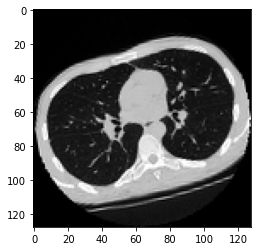

In [21]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

Since a CT scan has many slices, let's visualize a montage of the slices.  
一份CT扫描包含了很多个切片（可以理解为很多个帧），这里使用蒙太奇手法展示这些切片。  

（因为我不太懂蒙太奇手法，但从他代码上看就是简单的将样本逐一排列开）

In [22]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

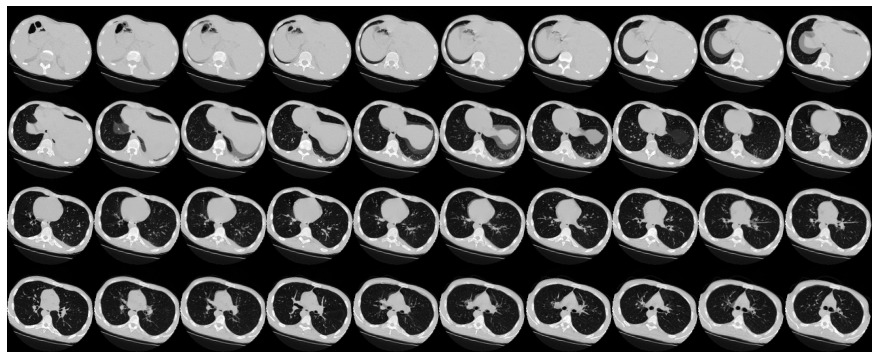

In [23]:
plot_slices(4, 10, 128, 128, image[:, :, :40])

-------------

## Define a 3D convolutional neural network
To make the model easier to understand, we structure it into blocks. The architecture of the 3D CNN used in this example is based on [this paper](https://arxiv.org/abs/2007.13224).  
模型结构参考了这篇 [论文](https://arxiv.org/abs/2007.13224)。  


In [24]:
def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [25]:
model = get_model(width=128, height=128, depth=64)

------------

## Train model

训练模型之前要对模型进行compile（编译），这里博主使用了 Keras 优化器方案中的学习率调整工具 [keras.optimizers.schedules.ExponentialDecay](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) 这个设置能让优化器学习率按照指数形式进行衰减，需要提供以下参数： 

1. initial_learning_rate： 初始学习率。
2. decay_steps： 衰减步数（多少个epoch衰减一次）。
3. decay_rate： 衰减率。
4. staircase：（布尔值）True衰减是突变的，False则是不断变化。  

在复杂问题上模型到了后期需要减小学习率以到达局部最优解，学习率如果始终保持一直可能会导致模型“总差那么一点点”，在最优解左右两侧反复横跳。

### 编译模型

In [26]:
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


### 定义回调函数

In [27]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [32]:
epochs = 20

In [33]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/20
70/70 - 18s - loss: 0.6498 - acc: 0.6643 - val_loss: 0.9559 - val_acc: 0.5000
Epoch 2/20
70/70 - 18s - loss: 0.6659 - acc: 0.6214 - val_loss: 1.2567 - val_acc: 0.5000
Epoch 3/20
70/70 - 18s - loss: 0.6551 - acc: 0.6286 - val_loss: 1.3464 - val_acc: 0.5000
Epoch 4/20
70/70 - 17s - loss: 0.6519 - acc: 0.6214 - val_loss: 1.1034 - val_acc: 0.5000
Epoch 5/20
70/70 - 19s - loss: 0.6478 - acc: 0.6357 - val_loss: 0.6181 - val_acc: 0.6833
Epoch 6/20
70/70 - 18s - loss: 0.6614 - acc: 0.6286 - val_loss: 0.6071 - val_acc: 0.6833
Epoch 7/20
70/70 - 18s - loss: 0.6433 - acc: 0.6714 - val_loss: 0.8103 - val_acc: 0.5667
Epoch 8/20
70/70 - 18s - loss: 0.6215 - acc: 0.6857 - val_loss: 0.5257 - val_acc: 0.6667
Epoch 9/20
70/70 - 18s - loss: 0.6347 - acc: 0.6214 - val_loss: 0.5614 - val_acc: 0.7000
Epoch 10/20
70/70 - 18s - loss: 0.6547 - acc: 0.5571 - val_loss: 0.7495 - val_acc: 0.5333
Epoch 11/20
70/70 - 18s - loss: 0.6027 - acc: 0.6857 - val_loss: 0.8904 - val_acc: 0.5667
Epoch 12/20
70/70 -

It is important to note that the number of samples is very small (only 200) and we don't specify a random seed. As such, you can expect significant variance in the results. The full dataset which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification performance is observed in both cases.  

需要注意的是，由于这里使用的样本量非常少（仅有200个），同时也没有设定随机种子。不难发现实验结果同预期之间存在较大差异，你可以通过 [这个链接](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1)获得完整的1000个样本的数据集，83%的判别准确率是比较容易实现的。无论是否使用完整的数据集，都可以看见验证集和训练集之间的判别准确率相差了大概 6-7% 左右。

-----------

## Visualizing model performance
### 模型性能可视化

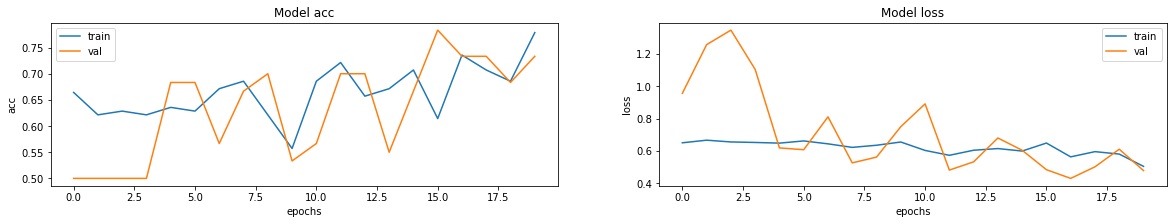

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

-----------

## Make predictions on a single CT scan
### 预测一个样本

In [35]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 21.85 percent confident that CT scan is normal
This model is 78.15 percent confident that CT scan is abnormal
